### Imports

In [22]:
# Visualization
import matplotlib.pyplot as plt

# Data related libraries
import numpy as np
import pandas as pd
import json

# Parameters handling libraries
from sklearn.model_selection import GridSearchCV

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn import metrics

### Configuration

In [2]:
EXPERIMENT = "tara"
ACTIVITIES = ["relaxing", "eating", "walking", "studying"]

### Dataset

In [3]:
def check_missing_values(dataset: pd.DataFrame, dataset_identifier: str):
    # Check if there are any remaining missing values
    missing_values = dataset.isnull().sum().sum()
    if missing_values > 0:
        print(f"There are still {missing_values} missing values in the [{dataset_identifier}]")
    else:
        print(f"All missing values have been filled in the [{dataset_identifier}]")


In [4]:
def fill_missing_data(dataset: pd.DataFrame):
    # Forward fill
    dataset = dataset.fillna(method='ffill')  
    # backward fill missing values
    dataset = dataset.fillna(method='bfill')
    return dataset

In [5]:
source_directory = "final_datasets"

# Loading `train` data
train_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_train_features.csv")
train_dataset = train_dataset.drop(['time'], axis=1)
check_missing_values(train_dataset, "train_dataset")
train_dataset = fill_missing_data(train_dataset)
check_missing_values(train_dataset, "train_dataset")
train_y = train_dataset[ACTIVITIES]
print("train_y", train_y.shape)
train_x = train_dataset.drop(ACTIVITIES, axis=1)
print("train_x", train_x.shape)

# Loading `test` data
test_dataset = pd.read_csv(f"{source_directory}/{EXPERIMENT}_test_features.csv")
test_dataset = test_dataset.drop(['time'], axis=1)
check_missing_values(test_dataset, "test_dataset")
test_dataset = fill_missing_data(test_dataset)
check_missing_values(test_dataset, "test_dataset")
test_y = test_dataset[ACTIVITIES]
print("test_y", test_y.shape)
test_x = test_dataset.drop(ACTIVITIES, axis=1)
print("test_x", test_x.shape)

There are still 1260 missing values in the [train_dataset]
All missing values have been filled in the [train_dataset]
train_y (21596, 4)
train_x (21596, 462)
There are still 1260 missing values in the [test_dataset]
All missing values have been filled in the [test_dataset]
test_y (3545, 4)
test_x (3545, 462)


In [9]:
def compute_grid_search_result(model_instance, parameters, X, y):
    grid_search_instance = GridSearchCV(model_instance, parameters)
    return grid_search_instance.fit(X, y)

def compute_metrics(test_y: np.ndarray, predicted_y: np.ndarray):
    accuracy_score = metrics.accuracy_score(test_y, predicted_y)
    precision_score = metrics.precision_score(test_y, predicted_y, average=None)
    recall_score = metrics.recall_score(test_y, predicted_y, average=None)
    f1_score = metrics.f1_score(test_y, predicted_y, average=None)
    roc_auc_score = metrics.roc_auc_score(test_y, predicted_y, average=None)
    
    return {
        "accuracy_score": accuracy_score,
        "precision_score": precision_score,
        "recall_score": recall_score,
        "f1_score": f1_score,
        "roc_auc_score": roc_auc_score,
    }

def add_new_key_value_to_dict(dict, key, value):
    dict[key] = value
    return dict

def fit_predict_and_compute_metrics(
        model_definition: type,
        parameters: dict,
        train_x: pd.DataFrame,
        train_y: pd.DataFrame,
        test_x: pd.DataFrame,
        test_y: pd.DataFrame
    ):

    model_instance: object = model_definition(**parameters)
    model_instance.fit(train_x, train_y)
    predicted_y: np.ndarray = model_instance.predict(test_x)
    metrics_result: dict = compute_metrics(test_y.values, predicted_y)
    return add_new_key_value_to_dict(metrics_result, "parameters", parameters)

In [17]:
def plot_results(results: dict, model_name: str):
    scores = {
        'Precision': results['precision_score'],
        'Recall': results['recall_score'],
        'F1-score': results['f1_score'],
        'Roc_auc_score': results['roc_auc_score']
    }

    _, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.2
    opacity = 0.8

    for i, (score_name, score_values) in enumerate(scores.items()):
        x = np.arange(len(score_values))
        bar_offset = i * bar_width
        ax.bar(x + bar_offset, score_values, bar_width, alpha=opacity, label=score_name)

    ax.set_xlabel('Activity')
    ax.set_ylabel('Score')
    ax.set_title(f'{model_name} Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(ACTIVITIES)
    ax.legend()
    plt.tight_layout()
    plt.show()
    
    for activity, score_values in zip(ACTIVITIES, zip(*scores.values())):
        print(f'{activity}: {dict(zip(scores.keys(), score_values))}')

## Random forest

Best parameters = {'max_depth': 15, 'min_samples_split': 7, 'n_estimators': 100}




C:\Users\tarar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


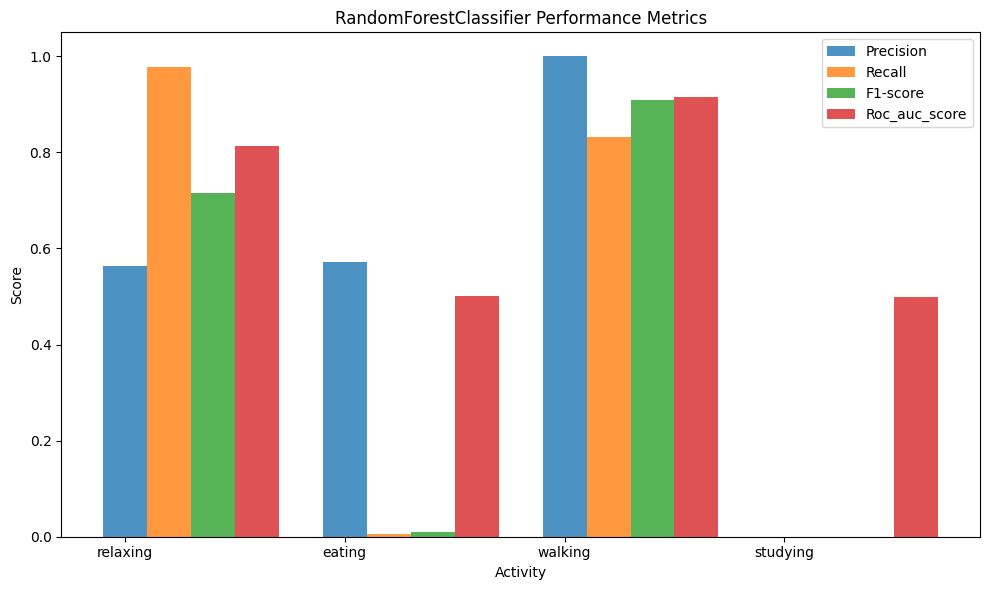

relaxing: {'Precision': 0.5645079041305456, 'Recall': 0.9787798408488063, 'F1-score': 0.7160413971539457, 'Roc_auc_score': 0.812505081981984}
eating: {'Precision': 0.5714285714285714, 'Recall': 0.004767580452920143, 'F1-score': 0.009456264775413711, 'Roc_auc_score': 0.5007769343078742}
walking: {'Precision': 1.0, 'Recall': 0.832807570977918, 'F1-score': 0.9087779690189328, 'Roc_auc_score': 0.9164037854889591}
studying: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}


In [41]:
random_forest_parameters = {
    "max_depth": [15], 
    "n_estimators" : [100],
    "min_samples_split" : [7]
}


random_forest_grid_search_result = compute_grid_search_result(
    RandomForestClassifier(),
    random_forest_parameters,
    train_x,
    train_y
)

print(f"Best parameters = {random_forest_grid_search_result.best_params_}\n\n")

random_forest_result: dict = fit_predict_and_compute_metrics(
    RandomForestClassifier,
    random_forest_grid_search_result.best_params_,
    train_x,
    train_y,
    test_x,
    test_y
)
    
        
plot_results(random_forest_result, "RandomForestClassifier")

## XGBClassifier

Best parameters = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 25}




C:\Users\tarar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


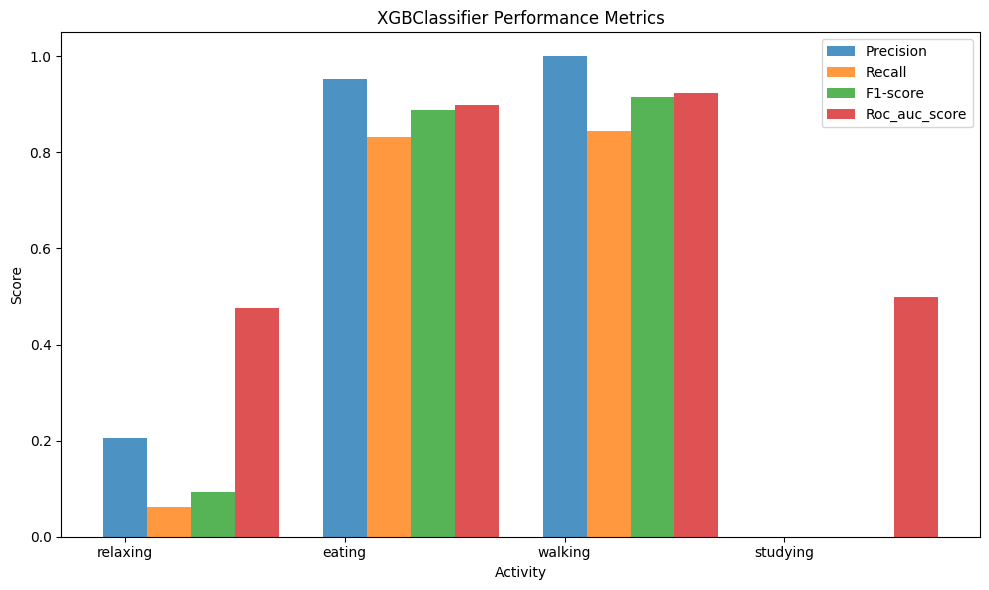

relaxing: {'Precision': 0.20597014925373133, 'Recall': 0.0610079575596817, 'F1-score': 0.09413369713506138, 'Roc_auc_score': 0.47540870123220214}
eating: {'Precision': 0.953551912568306, 'Recall': 0.831942789034565, 'F1-score': 0.8886059834500318, 'Roc_auc_score': 0.8977603607733081}
walking: {'Precision': 1.0, 'Recall': 0.8454258675078864, 'F1-score': 0.9162393162393162, 'Roc_auc_score': 0.9227129337539433}
studying: {'Precision': 0.0, 'Recall': 0.0, 'F1-score': 0.0, 'Roc_auc_score': 0.5}


In [19]:
svm_parameters = {
    'max_depth': [3],
    'n_estimators': [25],
    'learning_rate': [0.2],
}

xgb_grid_search_result = compute_grid_search_result(
    XGBClassifier(),
    svm_parameters,
    train_x,
    train_y
)
print(f"Best parameters = {xgb_grid_search_result.best_params_}\n\n")

xgb_result: dict = fit_predict_and_compute_metrics(
    XGBClassifier,
    xgb_grid_search_result.best_params_,
    train_x,
    train_y,
    test_x,
    test_y
)
plot_results(xgb_result, "XGBClassifier")